In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV

# модели
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

# стандартизация
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer

# метрики
from sklearn.metrics import (r2_score, accuracy_score, f1_score)

# кодирование признаков
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# понижение размерности
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

/home/w_lander/anaconda3/envs/dowgrade/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
from sklearn.datasets import fetch_20newsgroups

In [3]:
newsgroups = fetch_20newsgroups()

In [4]:
newsgroups.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [5]:
print(newsgroups.DESCR)

.. _20newsgroups_dataset:

The 20 newsgroups text dataset
------------------------------

The 20 newsgroups dataset comprises around 18000 newsgroups posts on
20 topics split in two subsets: one for training (or development)
and the other one for testing (or for performance evaluation). The split
between the train and test set is based upon a messages posted before
and after a specific date.

This module contains two loaders. The first one,
:func:`sklearn.datasets.fetch_20newsgroups`,
returns a list of the raw texts that can be fed to text feature
extractors such as :class:`~sklearn.feature_extraction.text.CountVectorizer`
with custom parameters so as to extract feature vectors.
The second one, :func:`sklearn.datasets.fetch_20newsgroups_vectorized`,
returns ready-to-use features, i.e., it is not necessary to use a feature
extractor.

**Data Set Characteristics:**

    =================   ==========
    Classes                     20
    Samples total            18846
    Dimensionality

Цель задания: Исследовать влияние различных методов понижения размерности на качество классификации текстовых данных.

Датасет: Набор данных новостных статей
(датасет '20 Newsgroups' доступный в sklearn.datasets).

### 1. Загрузите датасет '20 Newsgroups' из sklearn.

In [6]:
categories = ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale',]
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=('headers', 'footers', 'quotes'))

In [7]:
df = pd.DataFrame(newsgroups_train.data, columns=['text'])

In [8]:
y_train = pd.DataFrame(newsgroups_train.target, columns=['topics'])

In [9]:
df = df.join(y_train)

In [10]:
df.head()

,text,topics
0,\nTJ\nThis problem is most likely the same tha...,4
1,Archive-name: jpeg-faq\nLast-modified: 18 Apri...,1
2,I would like to sell my dot matrix printer so ...,6
3,"Moscow Scientific Inductrial Association ""Spec...",1
4,I'm look for current patches for color xterm f...,5


### 2. Проведите предобработку данных (очистка текста, удаление стоп-слов, векторизация с использованием TF-IDF).

In [11]:
import nltk
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/w_lander/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/w_lander/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/w_lander/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [12]:
stop_words = set(stopwords.words('english'))

In [13]:
import re

def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•<>·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    text = re.sub('n', ' ', text)

    return text


lemmatizer = WordNetLemmatizer()
def preprocess(text):
    # Токенизация по словам и приведение к нижнему регистру
    words = nltk.word_tokenize(text.lower())
    # Удаление стоп-слов и пунктуации
    filtered_words = [lemmatizer.lemmatize(word) for word in words if word.isalpha() and word not in stop_words]
    return ' '.join(filtered_words)

In [14]:
%%time
from tqdm import tqdm
tqdm.pandas()

df['text'] = df['text'].progress_apply(lambda x: clean_text(x))

100%|██████████████████████████████████████████████████████████████| 4001/4001 [00:02<00:00, 1767.14it/s]

CPU times: user 2.26 s, sys: 28.7 ms, total: 2.29 s
Wall time: 2.28 s


In [15]:
df.head()

,text,topics
0,tj this problem is most likely the same that a...,4
1,archive ame jpegfaq lastmodified april this...,1
2,i would like to sell my dot matrix pri ter so ...,6
3,"moscow scie tific i ductrial associatio ""spec...",1
4,i'm look for curre t patches for color xterm f...,5


In [16]:
%%time

df['text'] = df['text'].progress_apply(lambda x: preprocess(x))

100%|███████████████████████████████████████████████████████████████| 4001/4001 [00:07<00:00, 511.82it/s]

CPU times: user 7.73 s, sys: 102 ms, total: 7.84 s
Wall time: 7.82 s


In [17]:
df.head()

,text,topics
0,tj problem likely cx user experie ci g tha k e...,4
1,archive ame jpegfaq lastmodified april faq art...,1
2,would like sell dot matrix pri ter ca upgrade ...,6
3,moscow scie tific ductrial associatio spectrum...,1
4,look curre patch color xterm xr pl ro higher c...,5


In [18]:
df = df.drop(df[df['text'] == ''].index)

In [19]:
# Векторизация текста с помощью TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5_000, stop_words='english')
text_features = tfidf_vectorizer.fit_transform(df['text'])

In [20]:
text_features

<3905x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 166889 stored elements in Compressed Sparse Row format>

### 3. Примените к полученным векторам TF-IDF следующие методы понижения размерности:
* PCA (Principal Component Analysis)
* t-SNE (t-distributed Stochastic Neighbor Embedding)
* UMAP (Uniform Manifold Approximation and Projection).

### 6. Визуализируйте двумерное представление данных для каждого метода понижения размерности, чтобы оценить, как алгоритмы справляются с сепарацией классов.

In [21]:
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(text_features.toarray())

In [22]:
# Сколько информации сохранено в первых двух компонентах PCA
explained_variance = pca.explained_variance_ratio_
total_explained_variance = explained_variance.sum()
print(f'PCA - Total Explained Variance (information retained): {total_explained_variance:.2f}')

PCA - Total Explained Variance (information retained): 0.02


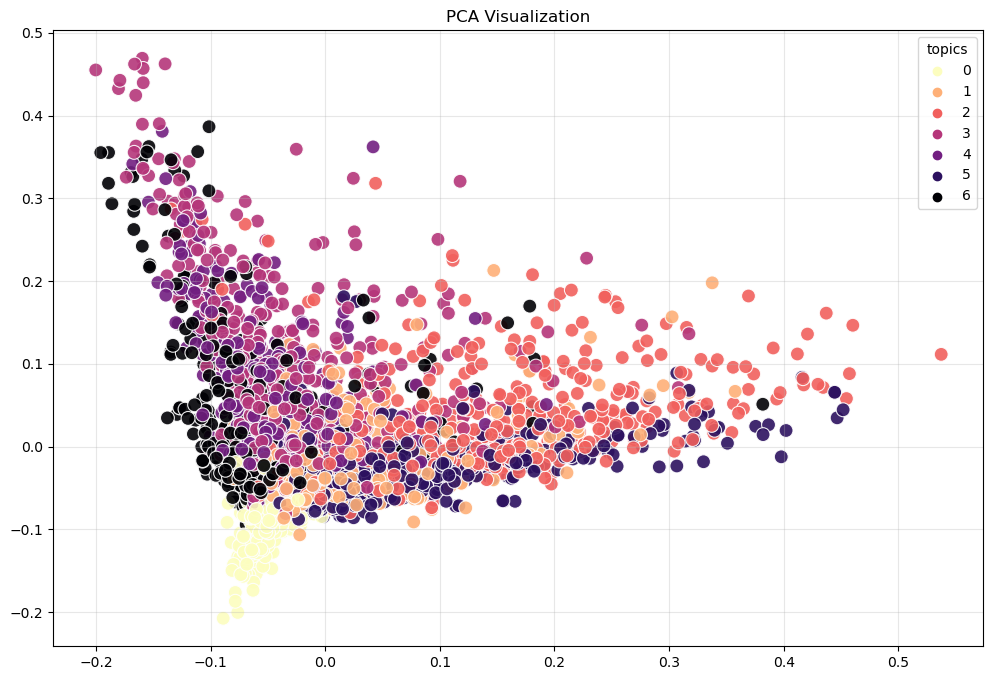

In [23]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=df['topics'], legend='full', alpha=0.9, s=100, palette='magma_r')
plt.title('PCA Visualization')
plt.grid(alpha=0.3)
plt.show()

### t-SNE

In [24]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_jobs=-1)
tsne_result = tsne.fit_transform(text_features.toarray())

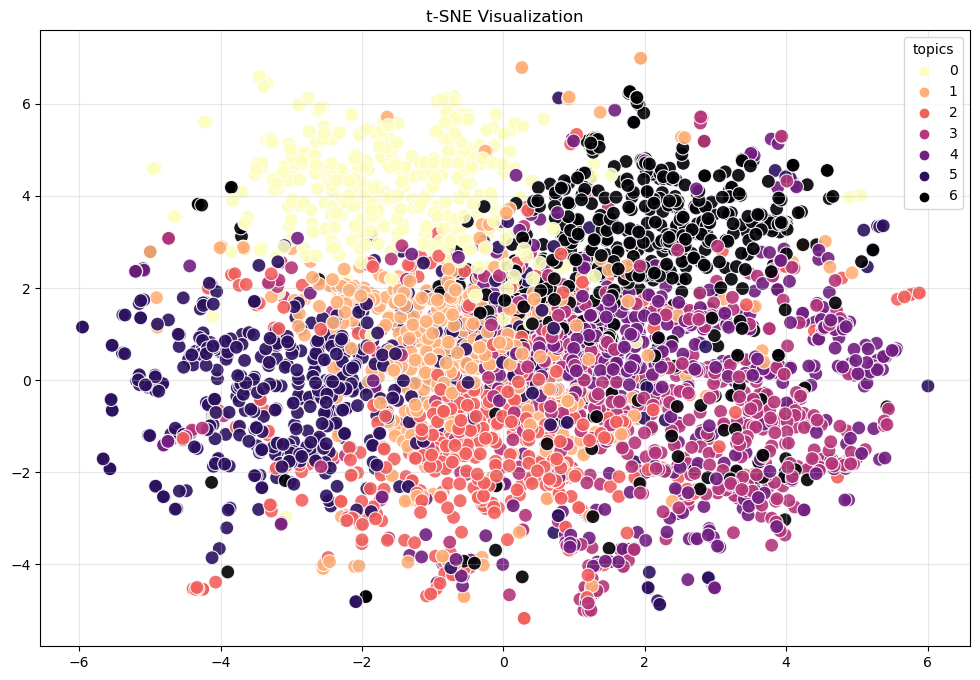

In [25]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=df['topics'], legend='full', alpha=0.9, s=100, palette='magma_r')
plt.title('t-SNE Visualization')
plt.grid(alpha=0.3)
plt.show()

### UMAP  

In [26]:
from umap import umap_

In [27]:
umap = umap_.UMAP(n_components=2, random_state=42, n_jobs=-1)
umap_result = umap.fit_transform(text_features.toarray())

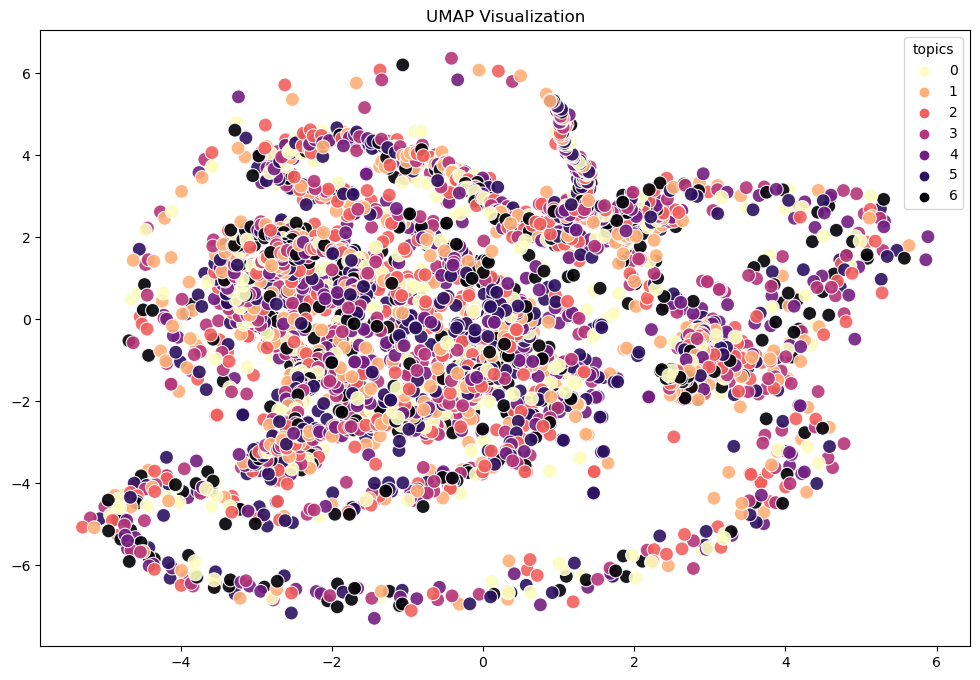

In [28]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x=umap_result[:, 0], y=umap_result[:, 1], hue=df['topics'], legend='full', alpha=0.9, s=100, palette='magma_r')
plt.title('UMAP Visualization')
plt.show()

### 4. После понижения размерности данных используйте любой метод машинного обучения для классификации новостей по темам.

### Построение модели

In [29]:
X_train, X_test, y_train, y_test = train_test_split(text_features, df['topics'], test_size=0.2, random_state=42)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(pca_result, df['topics'], test_size=0.2, random_state=42)
X_train_tsne, X_test_tsne, y_train_tsne, y_test_tsne = train_test_split(tsne_result, df['topics'], test_size=0.2, random_state=42)
X_train_umap, X_test_umap, y_train_umap, y_test_umap = train_test_split(umap_result, df['topics'], test_size=0.2, random_state=42)

In [30]:
# Функция для обучения модели и оценки метрик
def evaluate_model(X_train, X_test, y_train, y_test):
    classifier = RandomForestClassifier(random_state=42, max_depth=100, n_estimators=400, n_jobs=-1)
    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    return accuracy, f1

### 5. Сравните качество классификации для каждого метода понижения размерности. Используйте метрики точности и F1-меру.

In [31]:
accuracy, f1 = evaluate_model(X_train, X_test, y_train, y_test)
accuracy_pca, f1_pca = evaluate_model(X_train_pca, X_test_pca, y_train_pca, y_test_pca)
accuracy_tsne, f1_tsne = evaluate_model(X_train_tsne, X_test_tsne, y_train_tsne, y_test_tsne)
accuracy_umap, f1_umap = evaluate_model(X_train_umap, X_test_umap, y_train_umap, y_test_umap)

print(f'Без понижения размерности - Accuracy: {accuracy:.2f}, F1-score: {f1:.2f}')
print(f'PCA - Accuracy: {accuracy_pca:.2f}, F1-score: {f1_pca:.2f}')
print(f't-SNE - Accuracy: {accuracy_tsne:.2f}, F1-score: {f1_tsne:.2f}')
print(f'UMAP - Accuracy: {accuracy_umap:.2f}, F1-score: {f1_umap:.2f}')

Без понижения размерности - Accuracy: 0.70, F1-score: 0.70
PCA - Accuracy: 0.45, F1-score: 0.45
t-SNE - Accuracy: 0.64, F1-score: 0.64
UMAP - Accuracy: 0.23, F1-score: 0.23


In [46]:
# На выборке без понижения размерности 5000 получились - Accuracy 0.70, F1-score: 0.7
# Лучше всего показала себя моделль t-SNE - Accuracy: 0.64, F1-score: 0.64  размерности 2